## 自己定义一个网络结构
- 更新数据读取方式

In [13]:
# Import the necessary libraries
import numpy as np
import scipy
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import glob
%matplotlib inline
#from sklearn.cross_validation import StratifiedKFold

In [2]:
# Global Variables
BATCHSZ = 32
EPOCHS = 500

In [3]:
data_dir= "E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D"
data_root = glob.glob(data_dir + '/*')
print(data_root)

['E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\data.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\data_label.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\test.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\test_label.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\train.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\Salinas_w_size_9_num_200_for_2D\\train_label.npy']


In [4]:
for name in glob.glob(data_dir + '/*'):
    print(name)

E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\data.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\data_label.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\test.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\test_label.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\train.npy
E:\Eric_HSI\hyper_data_preprocess\Salinas_w_size_9_num_200_for_2D\train_label.npy


In [5]:
train = np.load(data_root[4])
train_label = np.load(data_root[5])
test = np.load(data_root[2])
test_label = np.load(data_root[3])
train.shape, train_label.shape, test.shape, test_label.shape

((3200, 9, 9, 204), (3200,), (50929, 9, 9, 204), (50929,))

In [6]:
# Reshape data into (numberofsumples, channels, height, width)

# convert class labels to on-hot encoding
train_label = utils.to_categorical(train_label)
test_label = utils.to_categorical(test_label)
train.shape, train_label.shape, test.shape, test_label.shape

((3200, 9, 9, 204), (3200, 16), (50929, 9, 9, 204), (50929, 16))

In [7]:
train.dtype, test.dtype, train_label.dtype, test_label.dtype

(dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'))

In [8]:
db_train = tf.data.Dataset.from_tensor_slices((train, train_label))
db_test = tf.data.Dataset.from_tensor_slices((test, test_label))

db_train = db_train.shuffle(train.shape[0]).batch(batch_size=BATCHSZ).repeat()
db_test = db_test.batch(batch_size=BATCHSZ)

In [9]:
db_train, db_test

(<RepeatDataset shapes: ((None, 9, 9, 204), (None, 16)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 9, 9, 204), (None, 16)), types: (tf.float32, tf.float32)>)

In [16]:
# Define the model structure
model = tf.keras.models.Sequential()

# filters, kernels（一般小于7）， strides 默认为1， padding 默认为valid
model.add(Conv2D(204, (1, 1), activation='relu', use_bias=False, input_shape=train[0].shape))
model.add(BatchNormalization())

model.add(Conv2D(102, (1, 1), activation='relu', use_bias=False))
model.add(BatchNormalization())

# 9 * 9 * 204 -> 21 *21 * 204
model.add(tf.keras.layers.Conv2DTranspose(64, 3, 2, 'valid', use_bias=False))
model.add(BatchNormalization())

# 21 * 21 * 204 -> 43 * 43 * 102
model.add(tf.keras.layers.Conv2DTranspose(32, 3, 2, 'valid', use_bias=False))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='softmax'))

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 9, 9, 204)         41616     
_________________________________________________________________
batch_normalization_5 (Batch (None, 9, 9, 204)         816       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 102)         20808     
_________________________________________________________________
batch_normalization_6 (Batch (None, 9, 9, 102)         408       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 19, 19, 64)        58752     
_________________________________________________________________
batch_normalization_7 (Batch (None, 19, 19, 64)        256       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 39, 39, 32)       

In [18]:
# Define optimization and train method
# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=10, min_lr=0.000001, verbose=1)
# checkpointer = ModelCheckpoint(filepath=".\checkP\.checkpoint.ckpt", verbose=1, save_best_only=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [19]:
# Start to train model 
history = model.fit(db_train,
                    batch_size=BATCHSZ, 
                    steps_per_epoch=train.shape[0]//BATCHSZ,
                    epochs=EPOCHS, 
                    validation_data=db_test, 
                    validation_steps=test.shape[0]//BATCHSZ,
                    callbacks=[reduce_lr])

Epoch 1/100
100/100 [==============================] - 8s 79ms/step - loss: 1.4625 - acc: 0.4947 - val_loss: 3.2818 - val_acc: 0.0141
Epoch 2/100
100/100 [==============================] - 8s 78ms/step - loss: 0.8202 - acc: 0.6791 - val_loss: 5.8022 - val_acc: 0.0171
Epoch 3/100
100/100 [==============================] - 8s 77ms/step - loss: 0.6131 - acc: 0.7594 - val_loss: 3.9405 - val_acc: 0.2474
Epoch 4/100
100/100 [==============================] - 8s 77ms/step - loss: 0.5201 - acc: 0.7969 - val_loss: 2.8464 - val_acc: 0.4135
Epoch 5/100
100/100 [==============================] - 8s 77ms/step - loss: 0.4665 - acc: 0.8206 - val_loss: 2.2045 - val_acc: 0.3174
Epoch 6/100
100/100 [==============================] - 8s 77ms/step - loss: 0.3601 - acc: 0.8550 - val_loss: 1.4281 - val_acc: 0.5923
Epoch 7/100
100/100 [==============================] - 8s 79ms/step - loss: 0.3444 - acc: 0.8706 - val_loss: 1.1025 - val_acc: 0.6912
Epoch 8/100
100/100 [==============================] - 8s 79ms

In [21]:
if not os.path.exists('model'):
    os.mkdir('model')

In [22]:
# save the model with h5py
model.save('./model/HSI_model.h5')

In [42]:
# using plot_model module to save the model figure
from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='./model/model.png', show_shapes=True)

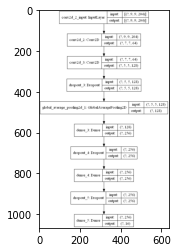

In [41]:
# show the model figure
model_img = plt.imread('./model/model.png')
# plt.figure(dpi=180)
plt.imshow(model_img)
plt.show()

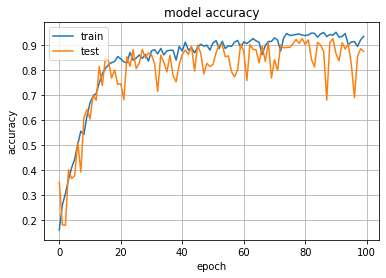

In [43]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
# plt.savefig("./result/model_accuracy_100.svg")
plt.show()

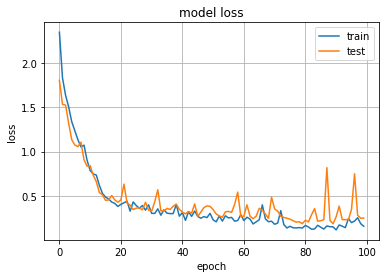

In [44]:
# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper right') 
# plt.savefig("./result/model_loss_100.svg")
plt.show()